In [77]:
# 패키지 로드
import pandas as pd                        
import numpy as np                         
import datetime as dt

# # 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 정규화, 표준화
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

# 군집화
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# 선형회귀
from sklearn.linear_model import LinearRegression

# 결정트리
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# RandomForest
from sklearn.ensemble import RandomForestRegressor

# lightgbm
import lightgbm

from sklearn.metrics import accuracy_score

In [2]:
dtypes = {"id":"int32", "breath_id":"int32","R":"int8","C":"int8","u_out":"category"}

train = pd.read_csv("data/train.csv", dtype = dtypes)
test = pd.read_csv("data/test.csv", dtype = dtypes)

In [3]:
combine = [train,test]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype   
---  ------     -----   
 0   id         int32   
 1   breath_id  int32   
 2   R          int8    
 3   C          int8    
 4   time_step  float64 
 5   u_in       float64 
 6   u_out      category
 7   pressure   float64 
dtypes: category(1), float64(3), int32(2), int8(2)
memory usage: 201.5 MB


In [5]:
train.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
id,6036000.0,3018000.500,1742443.257,1.000,1509000.750,3018000.500,4527000.250,6036000.000
breath_id,6036000.0,62838.859,36335.256,1.000,31377.000,62765.500,94301.000,125749.000
R,6036000.0,27.036,19.595,5.000,5.000,20.000,50.000,50.000
C,6036000.0,26.081,17.152,10.000,10.000,20.000,50.000,50.000
time_step,6036000.0,1.307,0.766,0.000,0.643,1.308,1.966,2.937
u_in,6036000.0,7.322,13.435,0.000,0.394,4.386,4.984,100.000
pressure,6036000.0,11.220,8.110,-1.896,6.330,7.033,13.641,64.821


<AxesSubplot:xlabel='time_step', ylabel='pressure'>

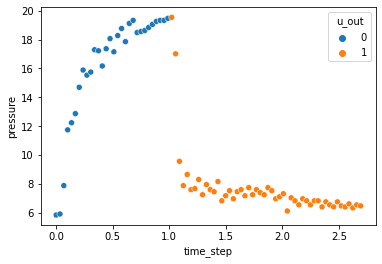

In [6]:
sns.scatterplot(data = train[train.breath_id==1], x="time_step",y="pressure",hue="u_out")

In [7]:
train[train["u_out"]=="1"].corr()

,id,breath_id,R,C,time_step,u_in,pressure
id,1.000000,0.999999,0.001922,0.007286,-0.000330,-0.001056,-0.001526
breath_id,0.999999,1.000000,0.001929,0.007287,-0.000338,-0.001062,-0.001523
R,0.001922,0.001929,1.000000,-0.099084,-0.022073,0.015652,-0.042443
C,0.007286,0.007287,-0.099084,1.000000,0.006006,-0.017316,0.028456
time_step,-0.000330,-0.000338,-0.022073,0.006006,1.000000,0.520589,-0.436533
u_in,-0.001056,-0.001062,0.015652,-0.017316,0.520589,1.000000,-0.153794
pressure,-0.001526,-0.001523,-0.042443,0.028456,-0.436533,-0.153794,1.000000


In [8]:
train[train["u_out"]=="0"].corr()

,id,breath_id,R,C,time_step,u_in,pressure
id,1.000000,0.999999,0.001739,0.007118,0.000020,-0.004132,-0.004680
breath_id,0.999999,1.000000,0.001746,0.007118,0.000015,-0.004135,-0.004680
R,0.001739,0.001746,1.000000,-0.091078,0.002563,-0.279047,0.053629
C,0.007118,0.007118,-0.091078,1.000000,-0.003587,0.283173,-0.098407
time_step,0.000020,0.000015,0.002563,-0.003587,1.000000,-0.233339,0.415618
u_in,-0.004132,-0.004135,-0.279047,0.283173,-0.233339,1.000000,0.098509
pressure,-0.004680,-0.004680,0.053629,-0.098407,0.415618,0.098509,1.000000


In [9]:
train["R/C"]=train["R"].astype("str")+train["C"].astype("str")

In [10]:
train.breath_id.nunique()

75450

In [11]:
len(train["R/C"].unique())

9

In [12]:
train.loc[train["breath_id"]==1,["R","C"]]

,R,C
0,20,50
1,20,50
2,20,50
3,20,50
4,20,50
...,...,...
75,20,50
76,20,50
77,20,50
78,20,50


In [13]:
len(train)/80

75450.0

In [14]:
train.breath_id.unique()

array([     1,      2,      3, ..., 125743, 125745, 125749])

In [16]:
train[train["breath_id"]==7]

,id,breath_id,R,C,time_step,u_in,u_out,pressure,R/C
480,481,7,50,20,0.000000,0.000000,0,6.399909,5020
481,482,7,50,20,0.034106,0.000000,0,6.048398,5020
482,483,7,50,20,0.068965,0.413631,0,6.329607,5020
483,484,7,50,20,0.103131,1.478318,0,6.470211,5020
484,485,7,50,20,0.137415,2.460097,0,6.610815,5020
...,...,...,...,...,...,...,...,...,...
555,556,7,50,20,2.582165,4.979613,1,6.470211,5020
556,557,7,50,20,2.616405,4.982821,1,6.470211,5020
557,558,7,50,20,2.651437,4.985581,1,6.540513,5020
558,559,7,50,20,2.685853,4.987860,1,6.681117,5020


<AxesSubplot:xlabel='time_step', ylabel='pressure'>

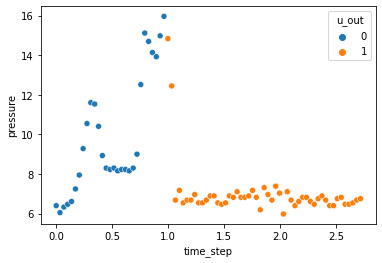

In [17]:
sns.scatterplot(data=train[train["breath_id"]==7],x="time_step",y="pressure",hue="u_out")

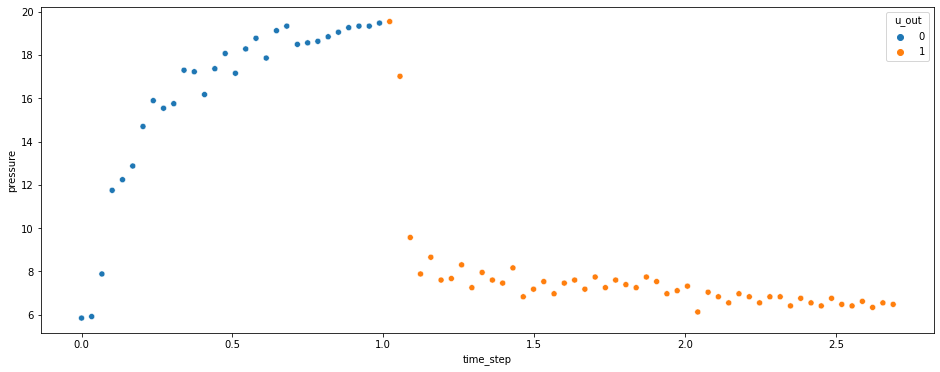

================================================== 1 ==================================================


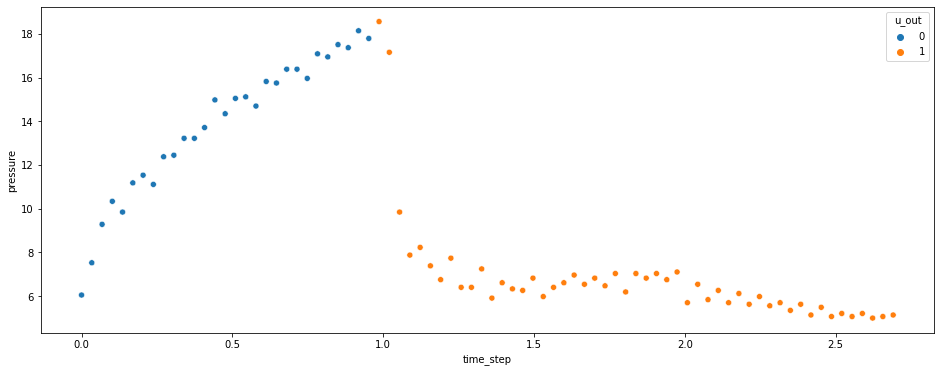

================================================== 2 ==================================================


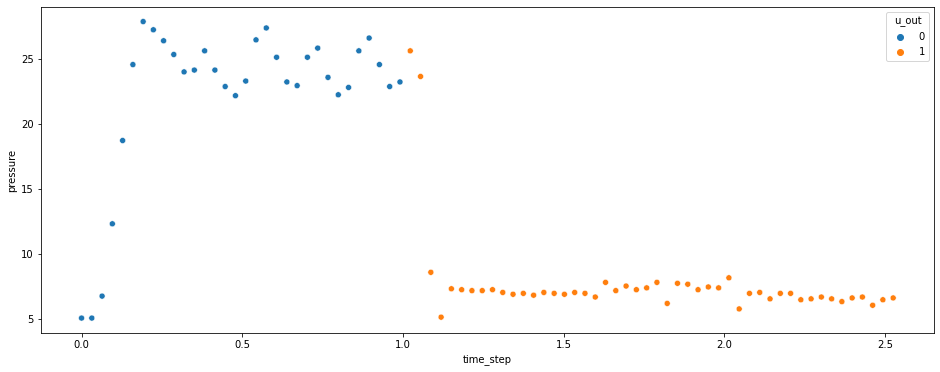

================================================== 3 ==================================================


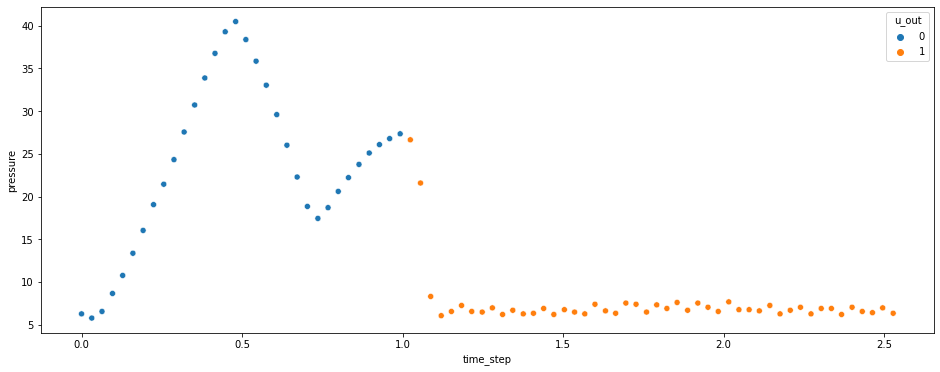

================================================== 4 ==================================================


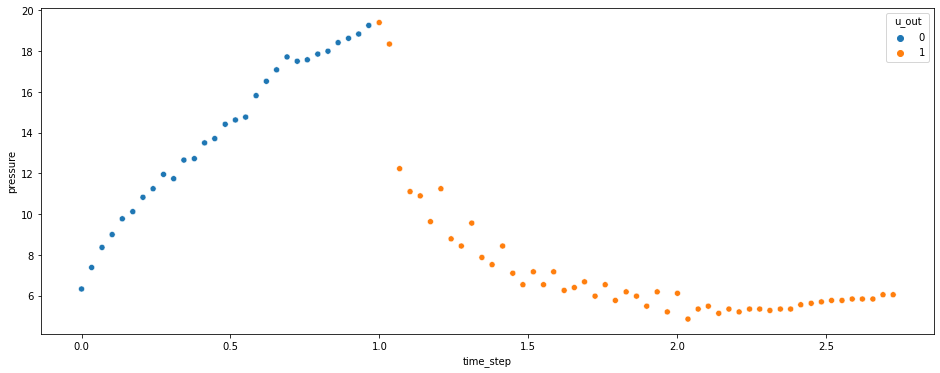

================================================== 5 ==================================================


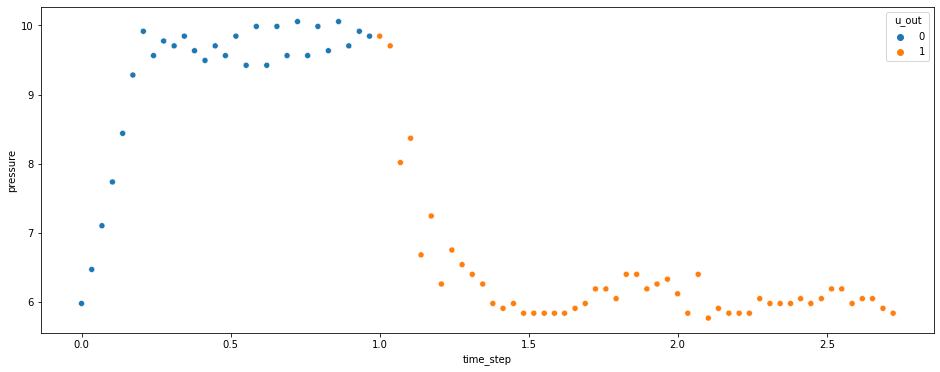

================================================== 6 ==================================================


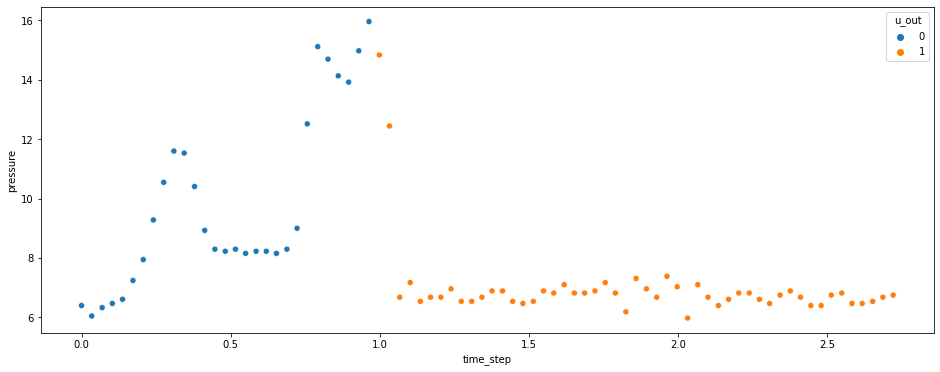

================================================== 7 ==================================================


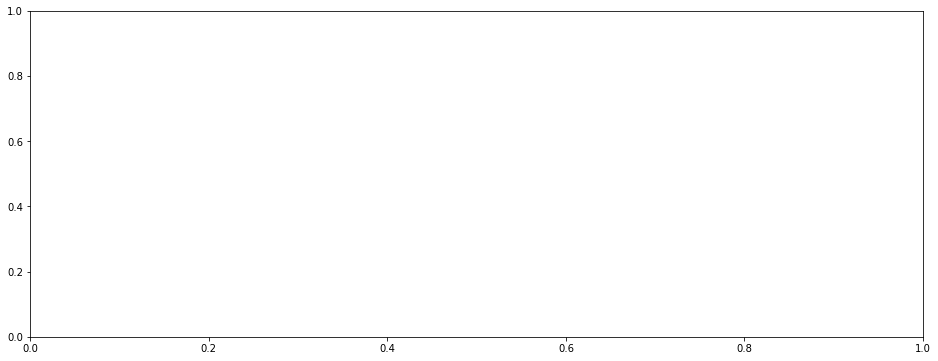

================================================== 8 ==================================================


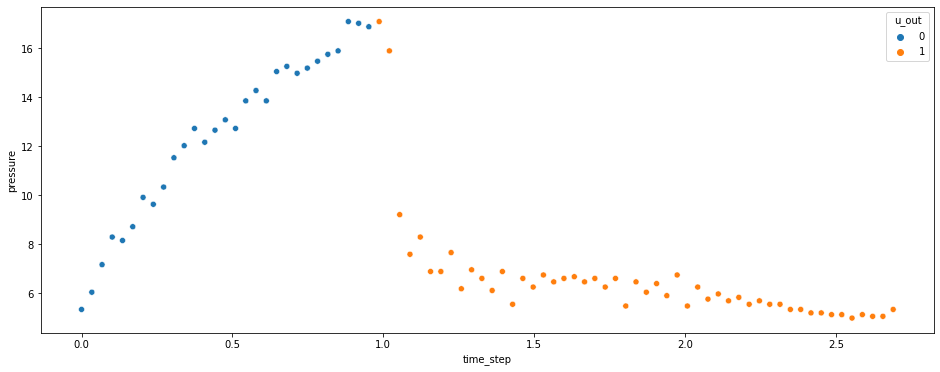

================================================== 9 ==================================================


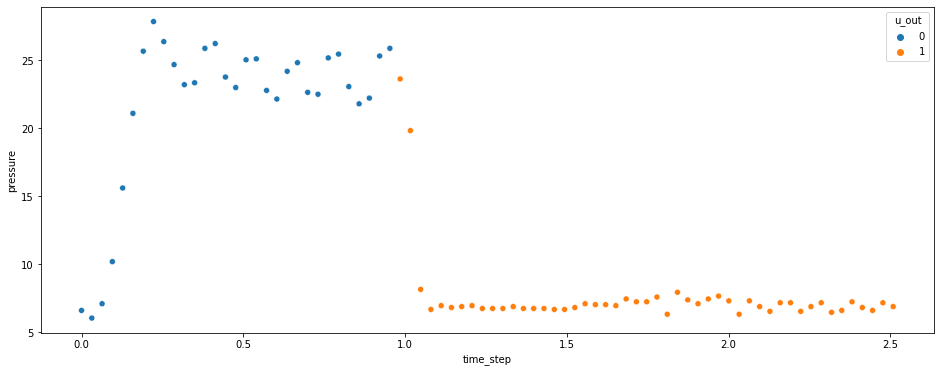

================================================== 10 ==================================================


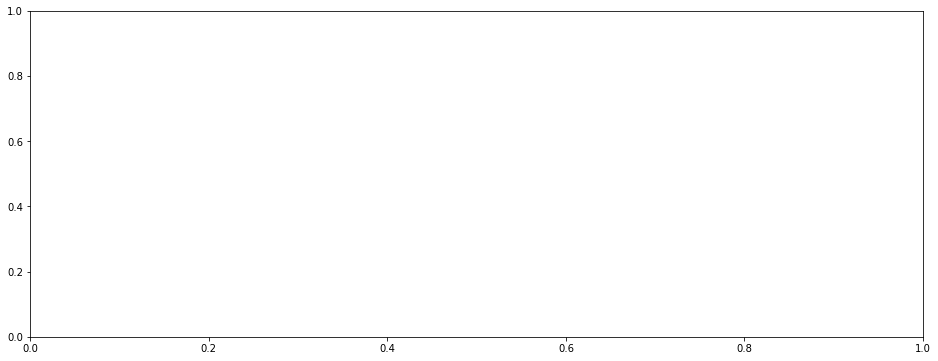

================================================== 11 ==================================================


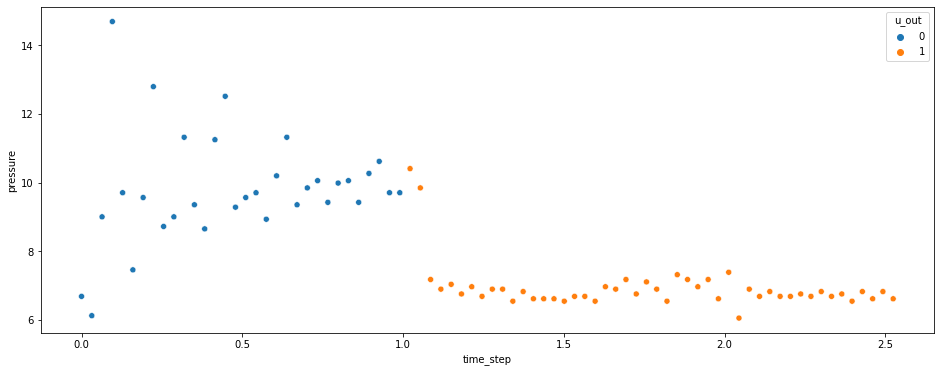

================================================== 12 ==================================================


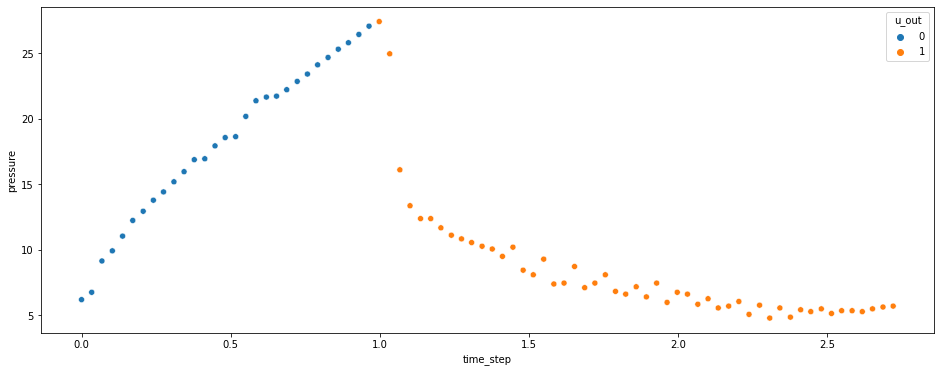

================================================== 13 ==================================================


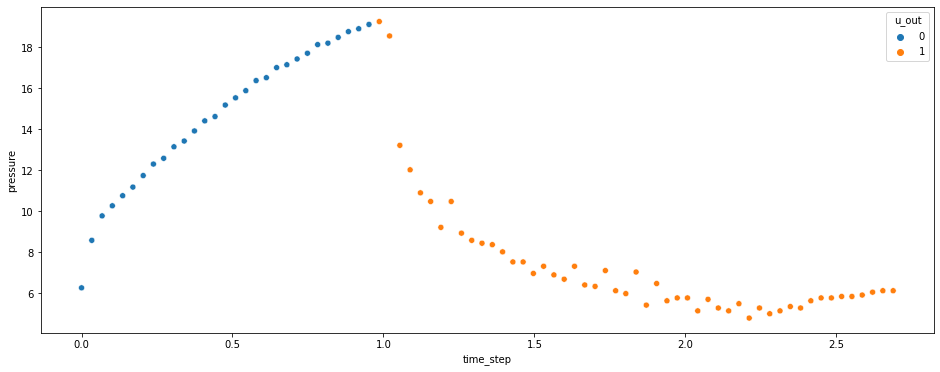

================================================== 14 ==================================================


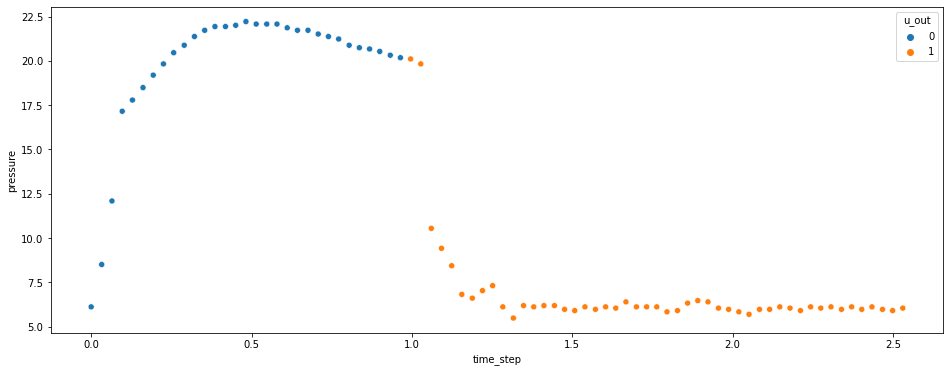

================================================== 15 ==================================================


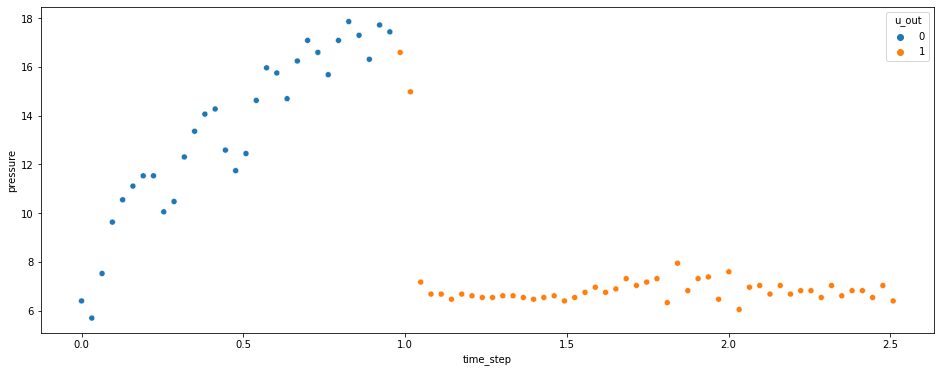

================================================== 16 ==================================================


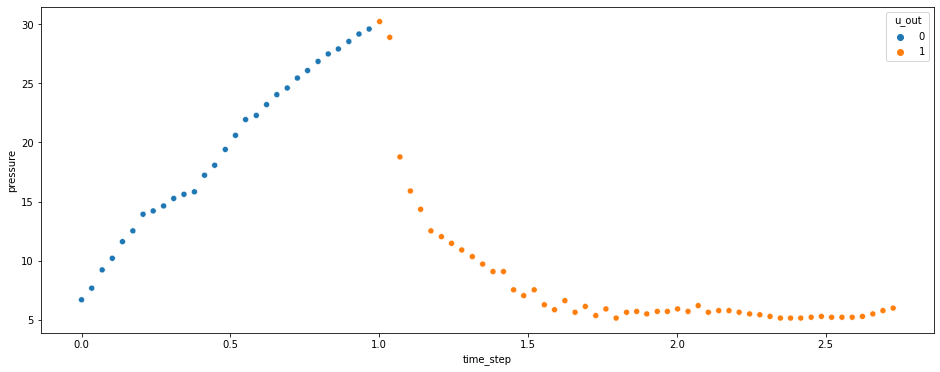

================================================== 17 ==================================================


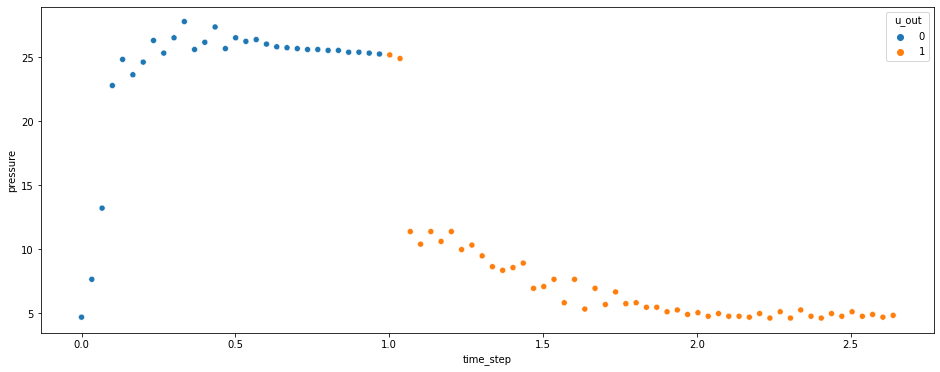

================================================== 18 ==================================================


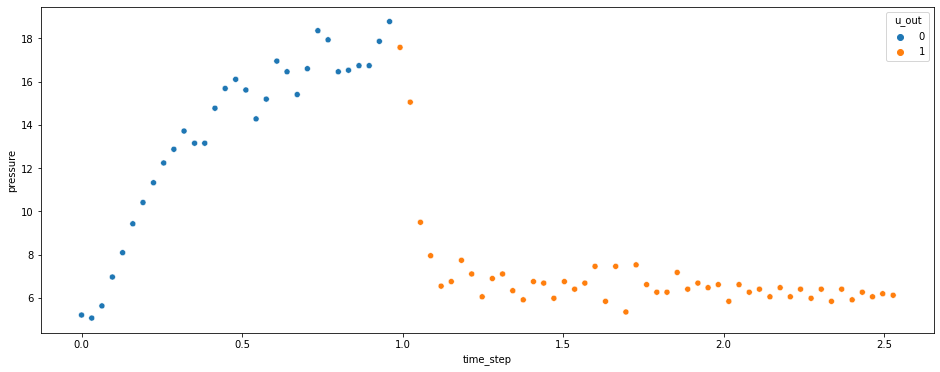

================================================== 19 ==================================================


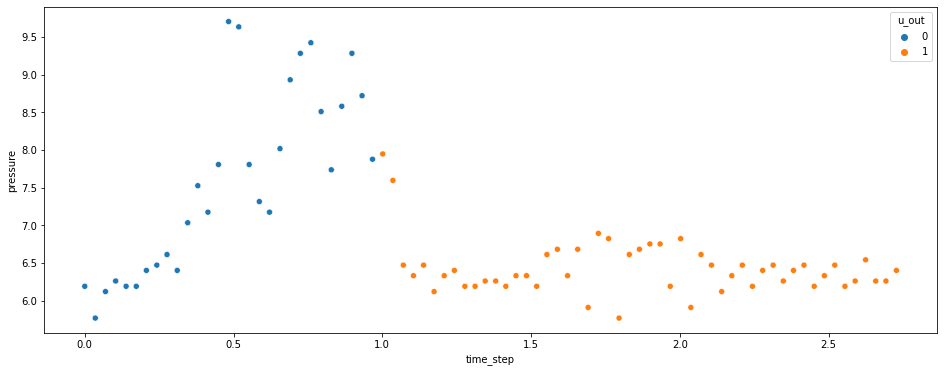

================================================== 20 ==================================================


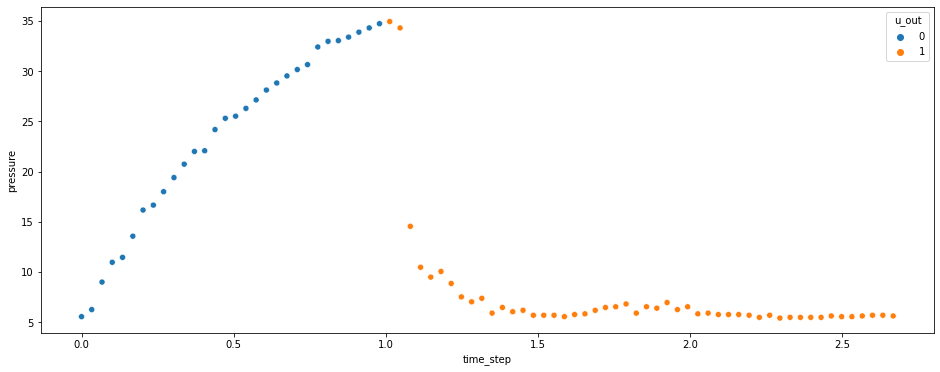

================================================== 21 ==================================================


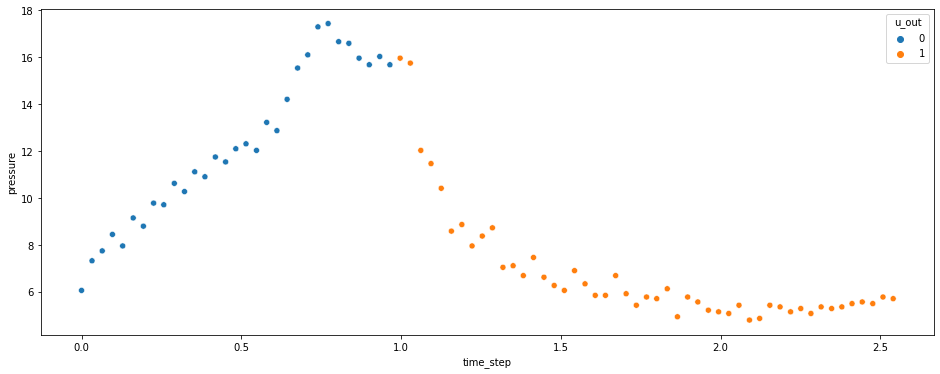

================================================== 22 ==================================================


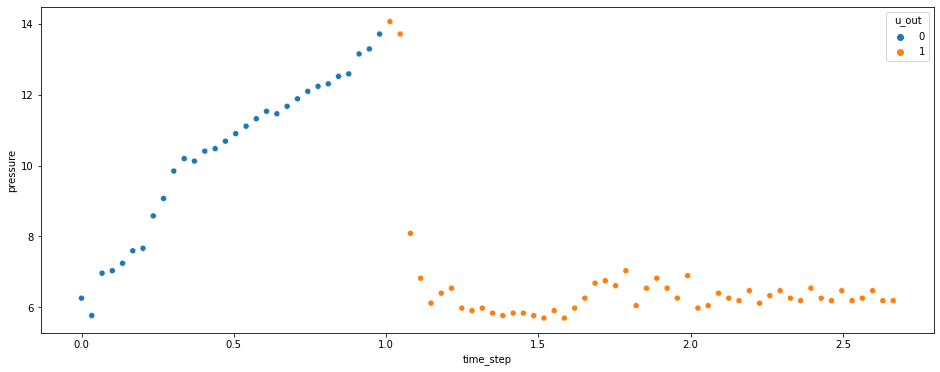

================================================== 23 ==================================================


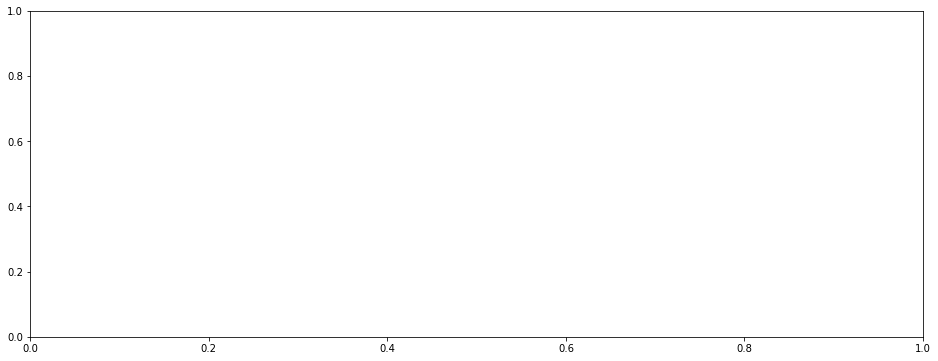

================================================== 24 ==================================================


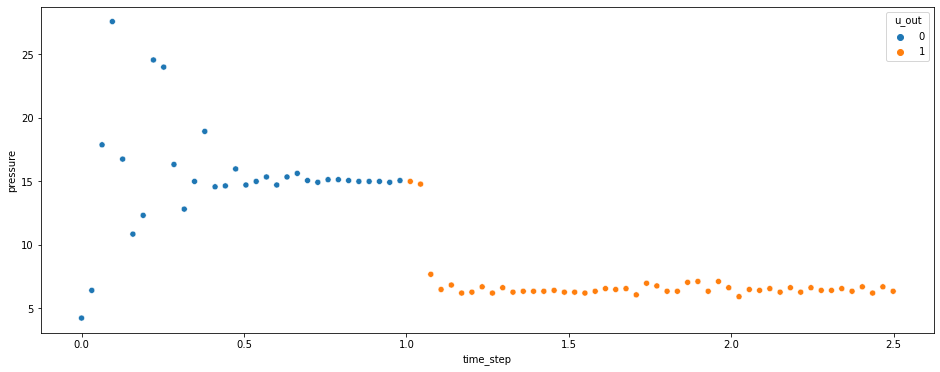

================================================== 25 ==================================================


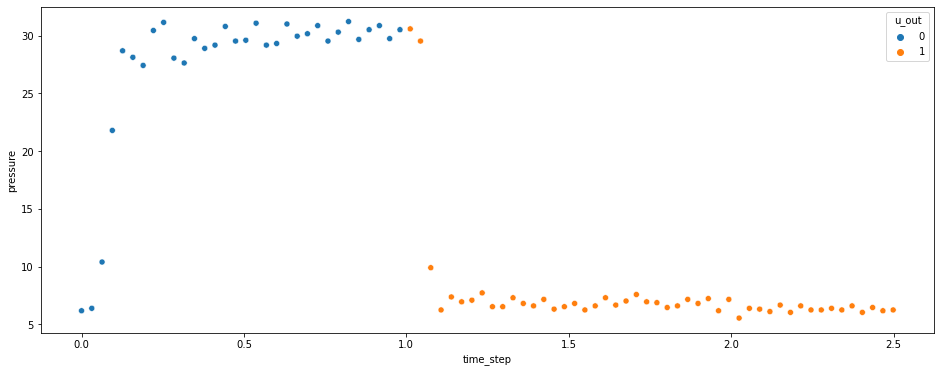

================================================== 26 ==================================================


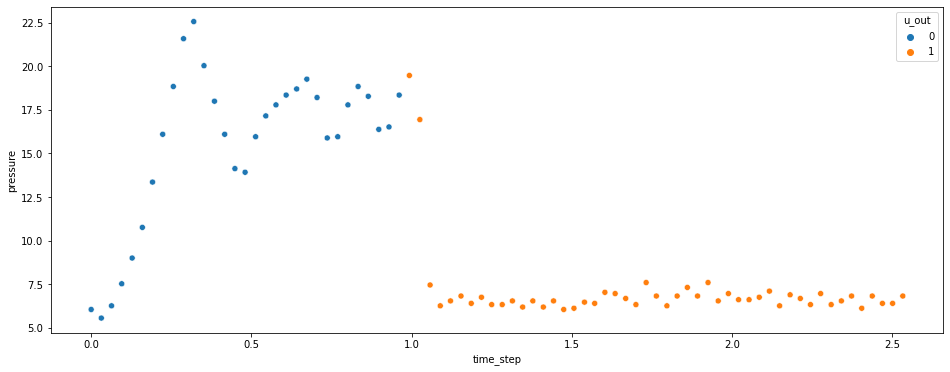

================================================== 27 ==================================================


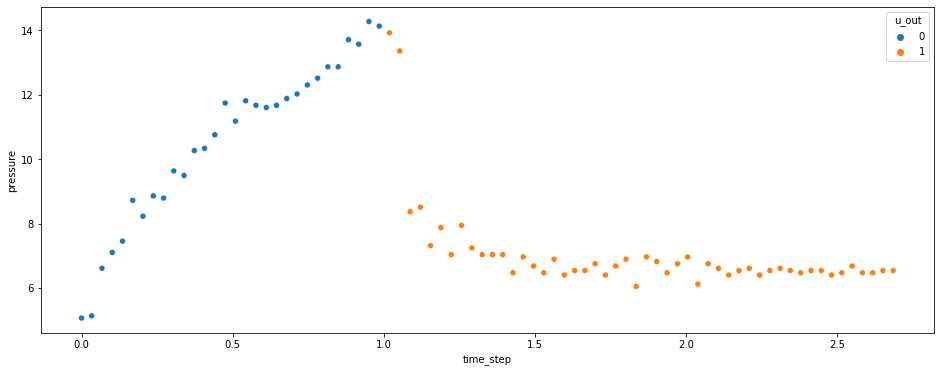

================================================== 28 ==================================================


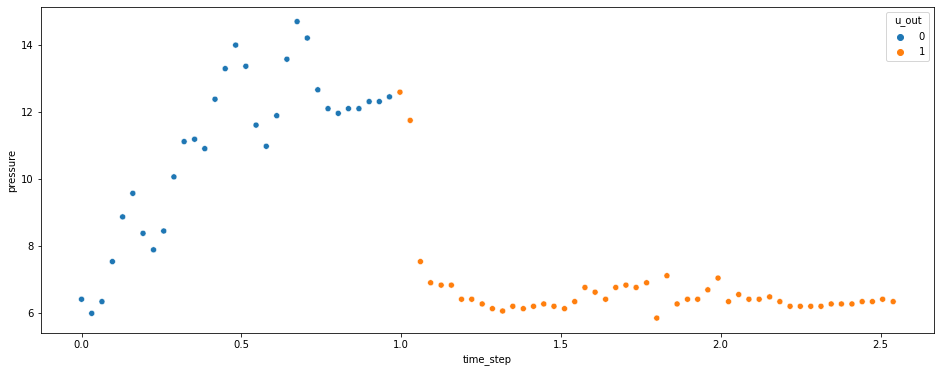

================================================== 29 ==================================================


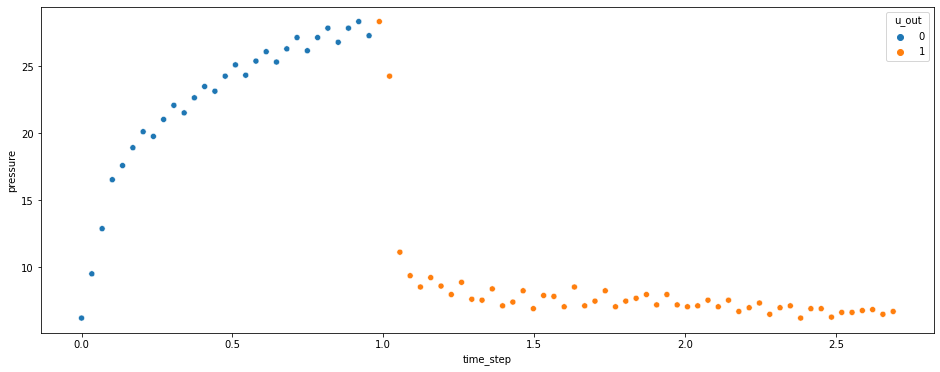

================================================== 30 ==================================================


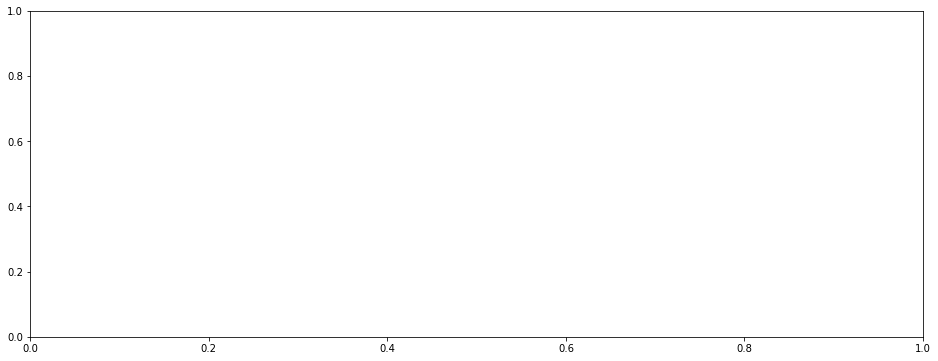

================================================== 31 ==================================================


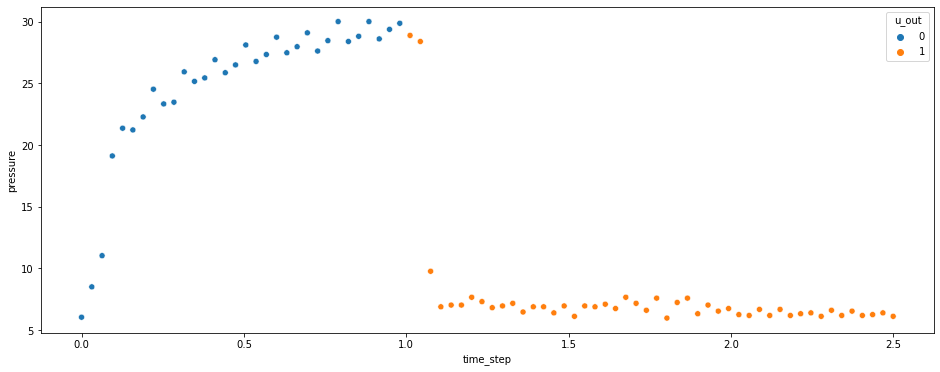

================================================== 32 ==================================================


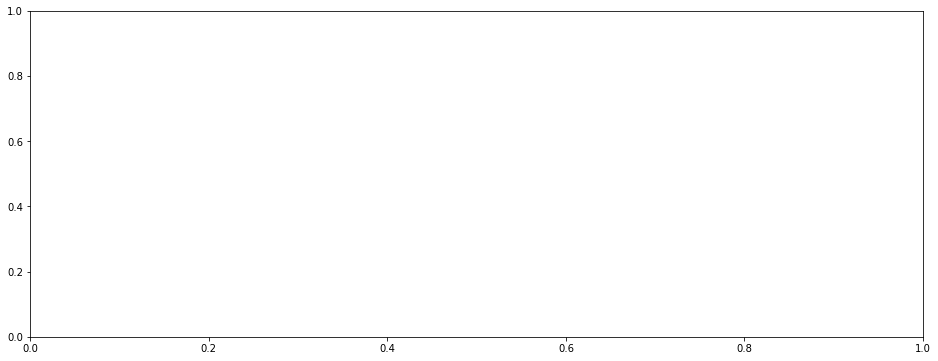

================================================== 33 ==================================================


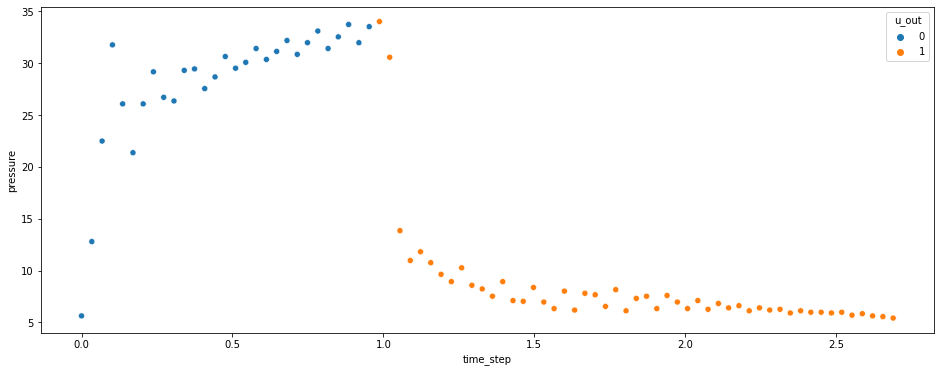

================================================== 34 ==================================================


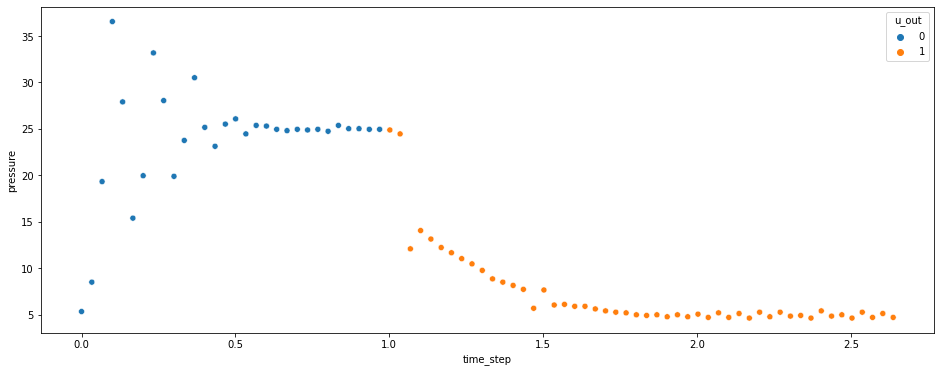

================================================== 35 ==================================================


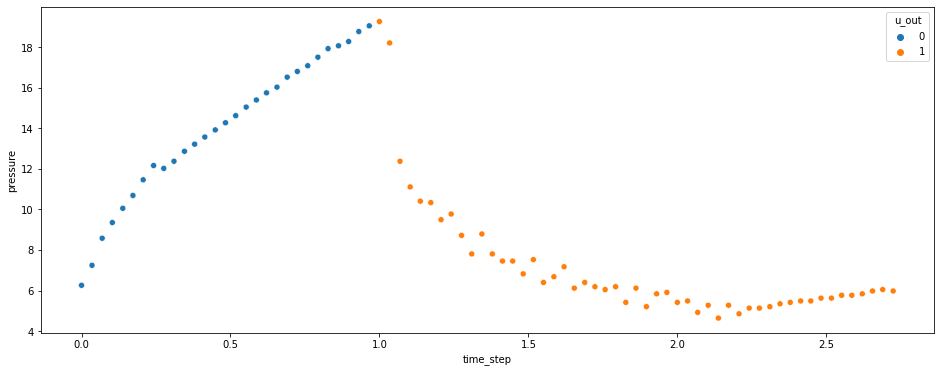

================================================== 36 ==================================================


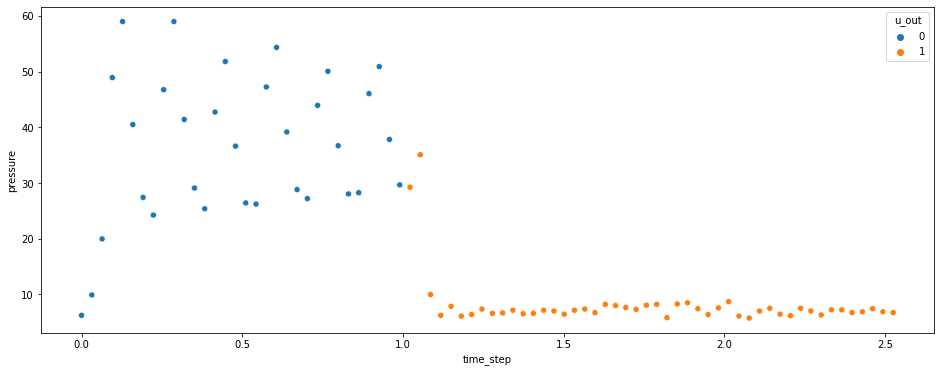

================================================== 37 ==================================================


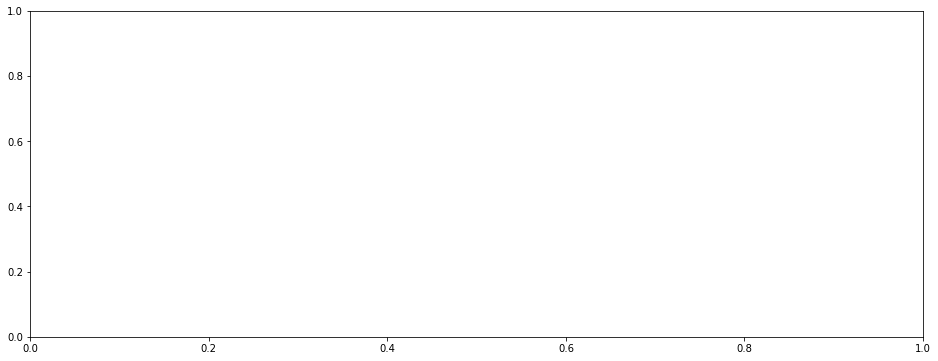

================================================== 38 ==================================================


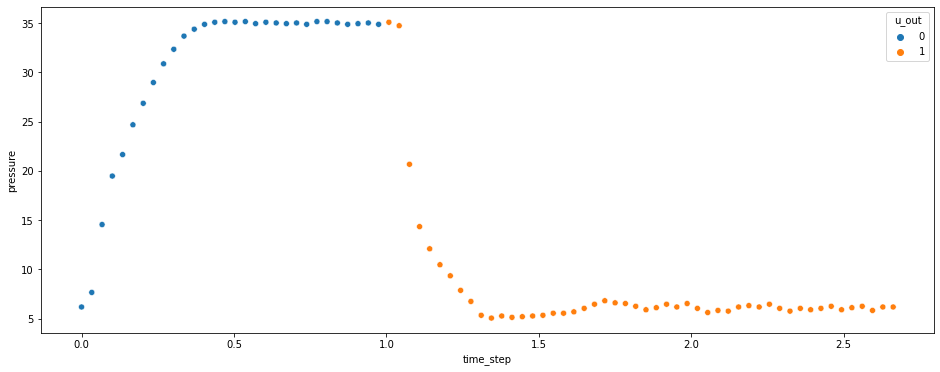

================================================== 39 ==================================================


In [18]:
for i in range(1,40):
    plt.figure(figsize=(16,6))
    sns.scatterplot(data=train[train["breath_id"]==i],x="time_step",y="pressure",hue="u_out")
#     plt.figure(figsize=(24,10))
    plt.show()
    print("="*50,i,"="*50)

pressure min 값이 마이너스 확인

<AxesSubplot:>

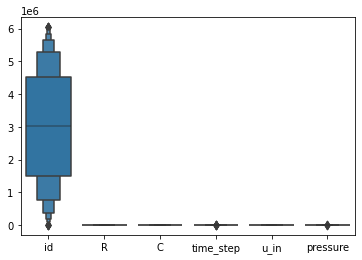

In [20]:
sns.boxenplot(data=train.drop(["breath_id"],axis=1))

In [24]:
# train['area'] = train['time_step'] * train['u_in']
# train['area'] = train.groupby('breath_id')['area'].cumsum()

In [41]:
train_df = train.drop("id",axis=1)
train_df

,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
6035995,125749,50,10,2.504603,1.489714,1,3.869032
6035996,125749,50,10,2.537961,1.488497,1,3.869032
6035997,125749,50,10,2.571408,1.558978,1,3.798729
6035998,125749,50,10,2.604744,1.272663,1,4.079938


In [42]:
train_df = pd.get_dummies(train_df,columns=["R","C"])
train_df

,breath_id,time_step,u_in,u_out,pressure,R_5,R_20,R_50,C_10,C_20,C_50
0,1,0.000000,0.083334,0,5.837492,0,1,0,0,0,1
1,1,0.033652,18.383041,0,5.907794,0,1,0,0,0,1
2,1,0.067514,22.509278,0,7.876254,0,1,0,0,0,1
3,1,0.101542,22.808822,0,11.742872,0,1,0,0,0,1
4,1,0.135756,25.355850,0,12.234987,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6035995,125749,2.504603,1.489714,1,3.869032,0,0,1,1,0,0
6035996,125749,2.537961,1.488497,1,3.869032,0,0,1,1,0,0
6035997,125749,2.571408,1.558978,1,3.798729,0,0,1,1,0,0
6035998,125749,2.604744,1.272663,1,4.079938,0,0,1,1,0,0


## 파생변수

### area

<AxesSubplot:>

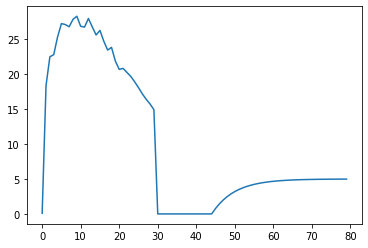

In [48]:
train_df[train_df["breath_id"]==1]["u_in"].plot()

<AxesSubplot:>

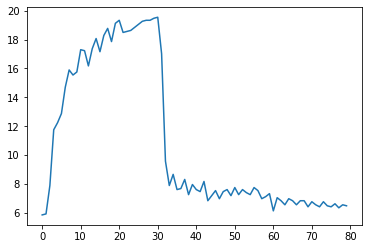

In [49]:
train_df[train_df["breath_id"]==1]["pressure"].plot()

In [82]:
train_df['area'] = train_df['time_step'] * train_df['u_in']

<AxesSubplot:>

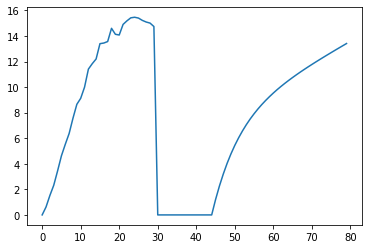

In [83]:
train_df[train_df["breath_id"]==1]["area"].plot()

u_in에 따라 구간을 3개로 나눠보는거? 들숨, u_in==0, 날숨

In [60]:
train_df["area"]

0          0.000000
1          0.618632
2          1.519701
3          2.316059
4          3.442197
             ...   
6035995    3.731141
6035996    3.777747
6035997    4.008767
6035998    3.314962
6035999    3.911492
Name: area, Length: 6036000, dtype: float64

<AxesSubplot:>

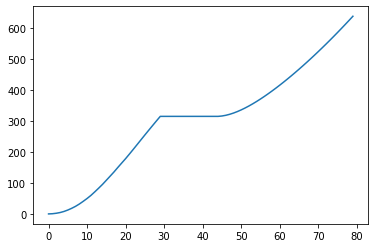

In [62]:
train_df.groupby('breath_id')['area'].cumsum()[:80].plot()

In [70]:
train_df["u_in"]

0           0.083334
1          18.383041
2          22.509278
3          22.808822
4          25.355850
             ...    
6035995     1.489714
6035996     1.488497
6035997     1.558978
6035998     1.272663
6035999     1.482739
Name: u_in, Length: 6036000, dtype: float64

In [73]:
(train_df["u_in"]).groupby(train_df["breath_id"]).shift(0)

0           0.083334
1          18.383041
2          22.509278
3          22.808822
4          25.355850
             ...    
6035995     1.489714
6035996     1.488497
6035997     1.558978
6035998     1.272663
6035999     1.482739
Name: u_in, Length: 6036000, dtype: float64

### u_in_cumsum

<AxesSubplot:>

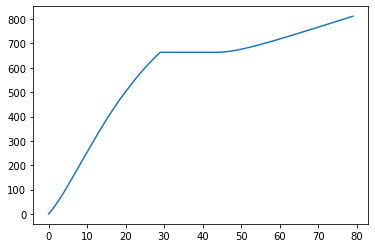

In [75]:
(train_df['u_in']).groupby(train_df['breath_id']).cumsum()[:80]

<AxesSubplot:>

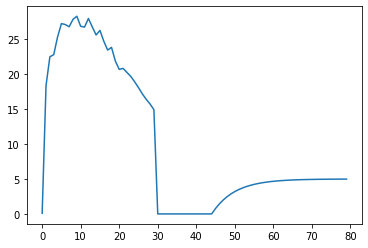

In [89]:
train_df["u_in"][:80].plot()

<AxesSubplot:>

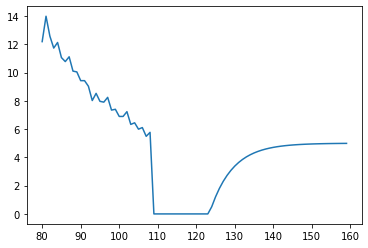

In [88]:
train_df["u_in"][80:160].plot()

In [94]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [100]:
train['breath_id'].nunique()

75450

In [98]:
(train["time_step"]==0).sum()

75450

In [108]:
((train["time_step"]==0)&(train["u_in"]<0.1)).sum()

24111

In [109]:
train[30:60]

,id,breath_id,R,C,time_step,u_in,u_out,pressure
30,31,1,20,50,1.021298,0.000000,1,19.546410
31,32,1,20,50,1.055426,0.000000,1,17.015533
32,33,1,20,50,1.089404,0.000000,1,9.563505
33,34,1,20,50,1.123387,0.000000,1,7.876254
34,35,1,20,50,1.157591,0.000000,1,8.649578
35,36,1,20,50,1.191510,0.000000,1,7.595045
36,37,1,20,50,1.225571,0.000000,1,7.665347
37,38,1,20,50,1.259531,0.000000,1,8.298067
38,39,1,20,50,1.293622,0.000000,1,7.243535
39,40,1,20,50,1.327631,0.000000,1,7.946556


<AxesSubplot:>

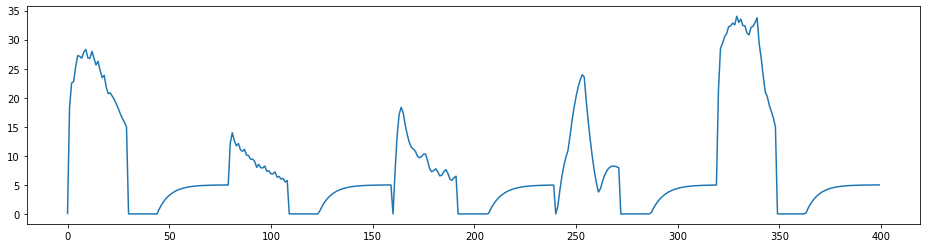

In [93]:
plt.figure(figsize=(16,4))
train_df["u_in"][:400].plot()

<AxesSubplot:>

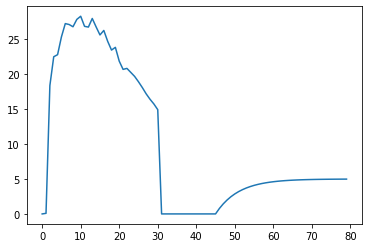

In [113]:
train_df['u_in_lag1'] = train_df.groupby('breath_id')['u_in'].shift(1)
train_df["u_in_lag1"].fillna(0,inplace=True)
train_df["u_in_lag1"][:80].plot()

In [148]:
train[train["u_out"]=="0"].groupby(["R","C"]).mean().reset_index()

,R,C,id,breath_id,time_step,u_in,pressure
0,5,10,3.016681e+06,62812.615319,0.486315,8.931976,19.279704
1,5,20,3.026511e+06,63015.837986,0.485107,21.017355,16.277408
2,5,50,2.993446e+06,62327.025348,0.483571,33.659473,14.619101
3,20,10,2.999818e+06,62459.515393,0.487284,8.510369,19.952772
4,20,20,2.992499e+06,62306.940309,0.483083,15.037749,17.898583
5,20,50,3.059812e+06,63711.627730,0.482779,21.199573,16.523440
6,50,10,2.997566e+06,62413.491459,0.485685,6.605410,17.365523
7,50,20,3.029793e+06,63086.005091,0.488849,9.581850,19.393914
8,50,50,3.049944e+06,63505.648477,0.485191,10.202984,17.816832


In [142]:
train[train["u_out"]=="1"].groupby(["R","C"]).mean().reset_index()

,R,C,id,breath_id,time_step,u_in,pressure
0,5,10,3.015896e+06,62795.366977,1.829531,2.920745,7.156241
1,5,20,3.025116e+06,62985.856455,1.786025,2.813117,7.959723
2,5,50,2.992571e+06,62307.970075,1.832917,2.940801,7.586384
3,20,10,3.000038e+06,62463.309714,1.817939,2.885160,7.130346
4,20,20,2.993824e+06,62333.713513,1.820473,2.910810,7.260080
5,20,50,3.059877e+06,63712.130898,1.829948,2.932976,7.330136
6,50,10,2.996998e+06,62400.806561,1.801515,3.221555,6.907215
7,50,20,3.028745e+06,63063.290129,1.794982,2.825927,7.499870
8,50,50,3.051939e+06,63546.484904,1.785094,2.800040,7.258813


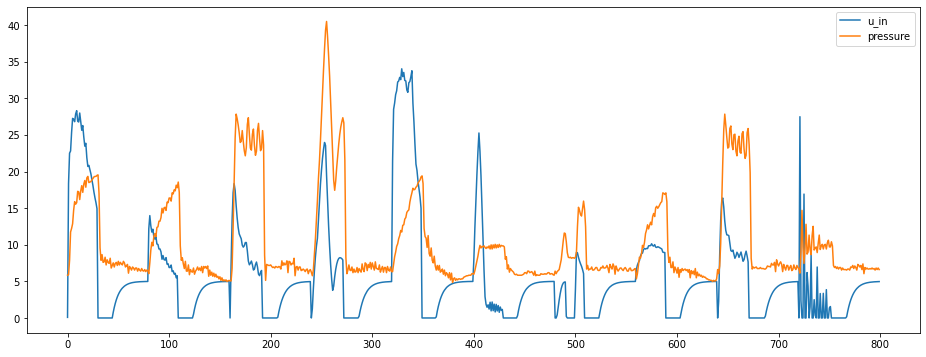

In [149]:
plt.figure(figsize=(16,6))
train_df["u_in"][:800].plot()
train_df["pressure"][:800].plot()
plt.legend()